🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
🔥 唤醒 5090... 准备进行 Q4 回测 (去噪聚合版)...
📂 正在筛选 Q4 数据...
✅ 筛选完成！Q4 共有 1079 条新闻。
==((====))==  Unsloth 2025.12.9: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    NVIDIA GeForce RTX 5090. Num GPUs = 1. Max memory: 31.357 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.12.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


🚀 开始推理...


100%|██████████| 1079/1079 [02:51<00:00,  6.31it/s]


✅ [表1] 新闻得分明细已保存: q4_news_details.csv

📊 每日聚合评分 (已过滤0分):
Date
2025-09-02    2.166667
2025-09-03    2.166667
2025-09-04    2.000000
2025-09-05    1.636364
2025-09-08    2.076923
Name: Score, dtype: float64

💰 下载 Q4 黄金价格...

🏆 2025 Q4 回测结果 (去噪版)
AI 策略收益: 28.70%
黄金基准收益: 24.19%
✅ [表2] 每日策略数据已保存: q4_strategy_daily.csv
✅ 图片已保存: q4_filtered_result.png


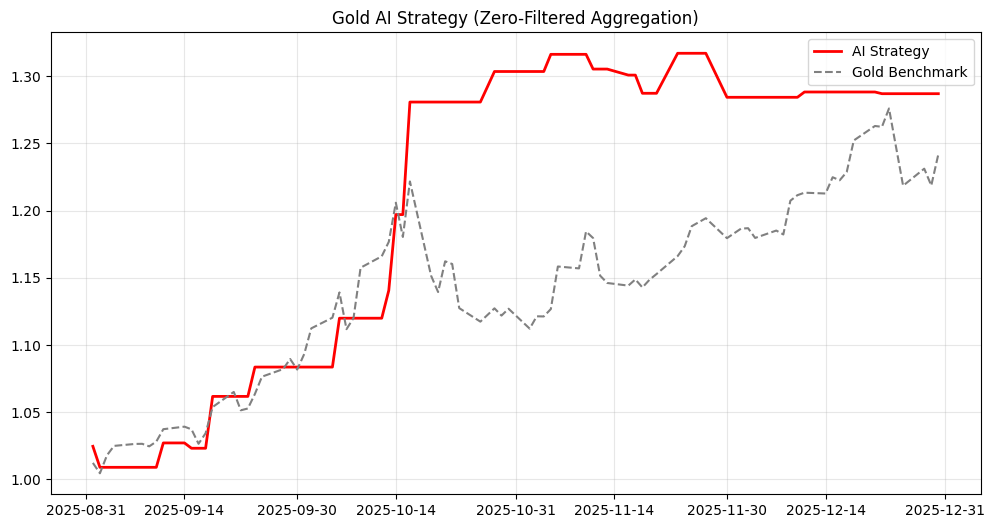

In [1]:
from unsloth import FastLanguageModel
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import json
import yfinance as yf
import matplotlib.pyplot as plt

# ================= 配置 =================
MODEL_PATH = "llama3_gold_quant_checkpoint"
TEST_JSONL = "gold_llm_test.jsonl"

# 目标月份：2025年 Q4
TARGET_MONTHS = ["2025-09","2025-10", "2025-11", "2025-12"]

# 策略阈值 (由于过滤了0分，分数会更极端，建议维持原判或微调)
LONG_THRESHOLD = 2.09
SHORT_THRESHOLD = 1.3

print(f"🔥 唤醒 5090... 准备进行 Q4 回测 (去噪聚合版)...")

# 1. 筛选数据
data_list = []
print("📂 正在筛选 Q4 数据...")
with open(TEST_JSONL, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            item = json.loads(line)
            date_line = item['input'].split('\n')[0]
            if any(month in date_line for month in TARGET_MONTHS):
                data_list.append(item)
        except: continue

print(f"✅ 筛选完成！Q4 共有 {len(data_list)} 条新闻。")
if len(data_list) == 0:
    print("❌ 错误：没找到数据。")
    exit()

# 2. 加载模型
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = MODEL_PATH,
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
)
FastLanguageModel.for_inference(model)

# 3. 批量推理
alpaca_prompt = """Below is an instruction that describes a task...
### Instruction:
{}
### Input:
{}
### Response:
"""

print(f"🚀 开始推理...")

dates = []
headlines = []
scores = []
raw_responses = []

for item in tqdm(data_list):
    # 解析日期和新闻标题 (用于生成详细报表)
    try:
        parts = item['input'].split('\n')
        date_str = parts[0].replace("Date: ", "").strip()
        headline_text = parts[1].replace("News: ", "").strip()
    except:
        date_str = "Unknown"
        headline_text = "Parse Error"

    inputs = tokenizer(
        [alpaca_prompt.format(item['instruction'], item['input'], "")],
        return_tensors = "pt"
    ).to("cuda")
    
    outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True, temperature=0.1)
    res = tokenizer.batch_decode(outputs)[0]
    
    response_part = res.split("### Response:")[-1].strip()
    
    # 提取分数逻辑 (优先找 Score: X，找不到找末尾数字)
    s = 0
    match = re.search(r"Score:\s*([+\-]?\d+)", response_part)
    if match:
        s = int(match.group(1))
    else:
        match_end = re.search(r"([+\-]?\d+)\s*(<\|end_of_text\|>)?$", response_part)
        s = int(match_end.group(1)) if match_end else 0
            
    dates.append(date_str)
    headlines.append(headline_text)
    scores.append(s)
    raw_responses.append(response_part)

# ================= 输出表格 1：新闻明细表 =================
df_news_detail = pd.DataFrame({
    'Date': dates,
    'Headline': headlines,
    'Score': scores,
    'Raw_Response': raw_responses
})
# 保存
df_news_detail.to_csv("q4_news_details.csv", index=False)
print(f"✅ [表1] 新闻得分明细已保存: q4_news_details.csv")


# ================= 4. 聚合数据 (核心修改：忽略 0 分) =================
df_pred = pd.DataFrame({'Date': dates, 'Score': scores})
df_pred['Date'] = pd.to_datetime(df_pred['Date'])

def non_zero_mean(x):
    """
    自定义聚合函数：
    1. 剔除所有 0 分。
    2. 计算剩余分数的平均值。
    3. 如果全是 0，则返回 0。
    """
    filtered = x[x != 0]
    if len(filtered) == 0:
        return 0.0
    return filtered.mean()

# 使用自定义函数进行聚合
daily_sentiment = df_pred.groupby('Date')['Score'].apply(non_zero_mean)

print("\n📊 每日聚合评分 (已过滤0分):")
print(daily_sentiment.head())

# ================= 5. 市场回测 =================
print("\n💰 下载 Q4 黄金价格...")
# 提前下载以计算 10-01 的收益
gold_price = yf.download("GC=F", start="2025-08-25", end="2026-01-10", progress=False)['Close']
gold_returns = gold_price.pct_change().shift(-1) # T+1 收益

# 对齐
strategy_df = pd.DataFrame(index=gold_returns.index)
strategy_df['Gold_Return'] = gold_returns
strategy_df = strategy_df.join(daily_sentiment.rename("Daily_Score"))

# 只保留 Q4
strategy_df = strategy_df.loc['2025-09-01':'2025-12-31']
# 填充空值：如果没有新闻或全是0分，分数为0
strategy_df['Daily_Score'] = strategy_df['Daily_Score'].fillna(0)

# 6. 计算收益
positions = []
pos_labels = []

for score in strategy_df['Daily_Score']:
    if score > LONG_THRESHOLD: 
        positions.append(2)
        pos_labels.append("Long")
    elif score < SHORT_THRESHOLD: 
        positions.append(-0.5)
        pos_labels.append("Short")
    else: 
        positions.append(0)
        pos_labels.append("Neutral")

strategy_df['Position'] = positions
strategy_df['Action'] = pos_labels
strategy_df['Strategy_Return'] = strategy_df['Position'] * strategy_df['Gold_Return']

strategy_df['Cumulative_Gold'] = (1 + strategy_df['Gold_Return']).cumprod()
strategy_df['Cumulative_Strategy'] = (1 + strategy_df['Strategy_Return']).cumprod()

final_ret = strategy_df['Cumulative_Strategy'].iloc[-1] - 1
gold_ret = strategy_df['Cumulative_Gold'].iloc[-1] - 1

print("\n" + "="*40)
print(f"🏆 2025 Q4 回测结果 (去噪版)")
print("="*40)
print(f"AI 策略收益: {final_ret*100:.2f}%")
print(f"黄金基准收益: {gold_ret*100:.2f}%")

# ================= 输出表格 2：每日策略表 =================
# 整理一下列的顺序，方便查看
output_columns = ['Daily_Score', 'Action', 'Position', 'Gold_Return', 'Strategy_Return', 'Cumulative_Strategy', 'Cumulative_Gold']
strategy_df[output_columns].to_csv("q4_strategy_daily.csv")
print(f"✅ [表2] 每日策略数据已保存: q4_strategy_daily.csv")

# 画图
plt.figure(figsize=(12, 6))
plt.plot(strategy_df.index, strategy_df['Cumulative_Strategy'], label='AI Strategy', color='red', linewidth=2)
plt.plot(strategy_df.index, strategy_df['Cumulative_Gold'], label='Gold Benchmark', color='gray', linestyle='--')
plt.title("Gold AI Strategy (Zero-Filtered Aggregation)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("q4_filtered_result.png")
print("✅ 图片已保存: q4_filtered_result.png")